#### Poszukiwanie tekstu pisanego odręcznie
Ten notatnik analizuje metody identyfikowania fragmentów pisanych odręcznie z obrazów zawierających tekst drukowany i pisany odręcznie za pomocą **DCNN**

Jako wejście algorytm przyjumuje plik png ze zbioru danych IAM z typem danych wejściowych i wyjściowych „form” i „bb” i formularz.

Na wyjściu otrzymujemy ramki ograniczające akapity.

In [2]:
import multiprocessing
import time
import random
import os

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import mxnet as mx
import numpy as np
from skimage.draw import line_aa
from skimage import transform as skimage_transform

from mxnet import nd, autograd, gluon
from mxnet.image import resize_short
from mxboard import SummaryWriter


from ocr.utils.iam_dataset import IAMDataset
from ocr.utils.iou_loss import IOU_loss
from ocr.utils.draw_box_on_image import draw_box_on_image

model_checkpoint_folder = "model_checkpoint"
if not os.path.isdir(model_checkpoint_folder):
    os.makedirs(model_checkpoint_folder)
    
ctx = mx.gpu()
mx.random.seed(42)

#### Wczytanie zbioru danych

In [4]:
train_ds = IAMDataset("form", output_data="bb", output_parse_method="form", train=True)
print("Number of training samples: {}".format(len(train_ds)))

test_ds = IAMDataset("form", output_data="bb", output_parse_method="form", train=False)
print("Number of testing samples: {}".format(len(test_ds)))

Processing data:
Completed: [--------------------------------------- ]  99%Number of training samples: 967
Number of testing samples: 232


Zastosowaliśmy dwie transformacje, funkcja „transform” zmienia rozmiar i normalizuje obraz. Funkcja „augment_transform” losowo przesuwa obraz i przewidywane pole ograniczające o 5%.

In [5]:
batch_size = 32

random_y_translation, random_x_translation = (0.2, 0.2) # Randomly translate the input image
expand_bb_scale = 0.03 # Expand the bounding box to relax the boundaries 

In [6]:
def transform(data, label):
    '''
    Function that converts "data"" into the input image tensor for a CNN
    Label is converted into a float tensor.
    '''
    image = mx.nd.array(data).expand_dims(axis=2)
    image = resize_short(image, int(800/3))
    image = image.transpose([2, 0, 1])/255.
    label = label[0].astype(np.float32)
    
    bb = label.copy()
    new_w = (1 + expand_bb_scale) * bb[2]
    new_h = (1 + expand_bb_scale) * bb[3]
    
    bb[0] = bb[0] - (new_w - bb[2])/2
    bb[1] = bb[1] - (new_h - bb[3])/2
    bb[2] = new_w
    bb[3] = new_h

    return image, mx.nd.array(bb)

def augment_transform(data, label):
    '''
    Function that randomly translates the input image by +-width_range and +-height_range.
    The labels (bounding boxes) are also translated by the same amount.
    '''
    ty = random.uniform(-random_y_translation, random_y_translation)
    tx = random.uniform(-random_x_translation, random_x_translation)
    st = skimage_transform.SimilarityTransform(translation=(tx*data.shape[1], ty*data.shape[0]))
    data = skimage_transform.warp(data, st)
    label = label.copy()
    label[0][0] = label[0][0] - tx
    label[0][1] = label[0][1] - ty
    return transform(data*255., label)

In [7]:
train_data = gluon.data.DataLoader(train_ds.transform(augment_transform), batch_size, shuffle=True, num_workers=8)
test_data = gluon.data.DataLoader(test_ds.transform(transform), batch_size, shuffle=False, num_workers=8)

#### Tworzenie sieci

In [9]:
class SegmentationNetwork(gluon.nn.HybridBlock):
    
    def __init__(self, p_dropout = 0.5, ctx=mx.cpu()):
        super(SegmentationNetwork, self).__init__()

        pretrained = gluon.model_zoo.vision.resnet34_v1(pretrained=True, ctx=ctx)
        first_weights = pretrained.features[0].weight.data().mean(axis=1).expand_dims(axis=1)

        body = gluon.nn.HybridSequential(prefix="SegmentationNetwork_")
        with body.name_scope():
            first_layer = gluon.nn.Conv2D(channels=64, kernel_size=(7, 7), padding=(3, 3), strides=(2, 2), in_channels=1, use_bias=False)
            first_layer.initialize(mx.init.Normal(), ctx=ctx)
            first_layer.weight.set_data(first_weights)
            body.add(first_layer)
            body.add(*pretrained.features[1:6])
        
            output = gluon.nn.HybridSequential()
            with output.name_scope():
                output.add(gluon.nn.Flatten())
                output.add(gluon.nn.Dense(64, activation='relu'))
                output.add(gluon.nn.Dropout(p_dropout))
                output.add(gluon.nn.Dense(64, activation='relu'))
                output.add(gluon.nn.Dropout(p_dropout))
                output.add(gluon.nn.Dense(4, activation='sigmoid'))

            output.collect_params().initialize(mx.init.Normal(), ctx=ctx)
            body.add(output)
        self.cnn = body

    def hybrid_forward(self, F, x):
        return self.cnn(x)

net = SegmentationNetwork()
net.hybridize()
net.collect_params().reset_ctx(ctx)

#### Definowanie epoki

In [11]:
print_every_n = 1
send_image_every_n = 20

def run_epoch(e, network, dataloader, loss_function, trainer, log_dir, print_name, is_train):
    total_loss = nd.zeros(1, ctx)
    for i, (data, label) in enumerate(dataloader):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        
        with autograd.record(train_mode=is_train):
            output = network(data)
            loss_i = loss_function(output, label)
        if is_train:
            loss_i.backward()
            trainer.step(data.shape[0])

        total_loss += loss_i.mean()
        
        if e % send_image_every_n == 0 and e > 0 and i == 0:
            output_image = draw_box_on_image(output.asnumpy(), label.asnumpy(), data.asnumpy())
    epoch_loss = float(total_loss .asscalar())/len(dataloader)
    
    with SummaryWriter(logdir=log_dir, verbose=False, flush_secs=5) as sw:
        sw.add_scalar('loss', {print_name: epoch_loss}, global_step=e)
        if e % send_image_every_n == 0 and e > 0:
            output_image[output_image<0] = 0
            output_image[output_image>1] = 1
            sw.add_image('bb_{}_image'.format(print_name), output_image, global_step=e)
            
    return epoch_loss

#### Pre training
Sieć była początkowo szkolona w 300 epokach przy użyciu błędu średniokwadratowego (strata L2) jako funkcji straty. Zostało to wykonane, ponieważ bez rozsądnych ramek granicznych (tj. nakładających się ramek granicznych) utrata IOU nie będzie działać poprawnie.

In [14]:
checkpoint_name = "cnn_mse.params"
best_test_loss = 10e5

In [17]:
loss_function = gluon.loss.L2Loss()
epochs = 11
learning_rate = 0.00005
log_dir = "./logs/paragraph_segmentation"

In [19]:
if os.path.isfile(os.path.join(model_checkpoint_folder, checkpoint_name)):
    net.load_parameters(os.path.join(model_checkpoint_folder, checkpoint_name))


In [21]:
trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': learning_rate})

In [22]:
for e in range(epochs):
    train_loss = run_epoch(e, net, train_data, loss_function=loss_function, log_dir=log_dir, 
                           trainer=trainer, print_name="train", is_train=True)
    test_loss = run_epoch(e, net, test_data, loss_function=loss_function, log_dir=log_dir,
                          trainer=trainer, print_name="test", is_train=False)
    if test_loss < best_test_loss:
        print("Saving network, previous best test loss {:.6f}, current test loss {:.6f}".format(best_test_loss, test_loss))
        net.save_parameters(os.path.join(model_checkpoint_folder, checkpoint_name))
        best_test_loss = test_loss
    if e % print_every_n == 0 and e > 0:
        print("Epoch {0}, train_loss {1:.6f}, test_loss {2:.6f}".format(e, train_loss, test_loss))

[09:27:18] ../src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:97: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


Saving network, previous best test loss 1000000.000000, current test loss 0.002516
Saving network, previous best test loss 0.002516, current test loss 0.001363
Epoch 1, train_loss 0.008476, test_loss 0.001363
Saving network, previous best test loss 0.001363, current test loss 0.001273
Epoch 2, train_loss 0.006936, test_loss 0.001273
Epoch 3, train_loss 0.006079, test_loss 0.001371
Saving network, previous best test loss 0.001273, current test loss 0.001209
Epoch 4, train_loss 0.005319, test_loss 0.001209
Saving network, previous best test loss 0.001209, current test loss 0.001129
Epoch 5, train_loss 0.004649, test_loss 0.001129
Saving network, previous best test loss 0.001129, current test loss 0.001077
Epoch 6, train_loss 0.004192, test_loss 0.001077
Saving network, previous best test loss 0.001077, current test loss 0.001073
Epoch 7, train_loss 0.003999, test_loss 0.001073
Saving network, previous best test loss 0.001073, current test loss 0.001023
Epoch 8, train_loss 0.003723, test_

#### Dopasowanie
Po przeszkoleniu sieci za pomocą średniej kwadratowej utraty błędów, utrata IOU została wykorzystana do dostrojenia sieci. Strata IOU jest bardziej drobnoziarnista, ponieważ maksymalizuje nakładanie się ramek ograniczających.

In [24]:
if os.path.isfile(os.path.join(model_checkpoint_folder, checkpoint_name)):
    net.load_parameters(os.path.join(model_checkpoint_folder, checkpoint_name))

fine_tuning = False # I found this to consistently decrease the qualitative results

In [25]:
if fine_tuning:
    checkpoint_name = "cnn_iou.params"
    loss_function = IOU_loss()
    epochs = 150
    learning_rate = 0.00005
    log_dir = "./logs"

    best_test_loss = 10e5

    trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': learning_rate, })

    for e in range(epochs):
        train_loss = run_epoch(e, net, train_data, loss_function=loss_function, log_dir=log_dir, 
                               trainer=trainer, print_name="train", is_train=True)
        test_loss = run_epoch(e, net, test_data, loss_function=loss_function, log_dir=log_dir,
                              trainer=trainer, print_name="test", is_train=False)
        if test_loss < best_test_loss:
            print("Saving network, previous best test loss {:.6f}, current test loss {:.6f}".format(best_test_loss, test_loss))
            net.save_parameters("{}/{}".format(model_checkpoint_folder, checkpoint_name))
            best_test_loss = test_loss
        if e % print_every_n == 0 and e > 0:
            print("Epoch {0}, train_loss {1:.6f}, test_loss {2:.6f}".format(e, train_loss, test_loss))

#### Wyniki
Szkolenie i test MSE są wyświetlone w tym notatniku. Stratę i obrazy z przewidywanymi ramkami ograniczającymi pokazano poniżej.

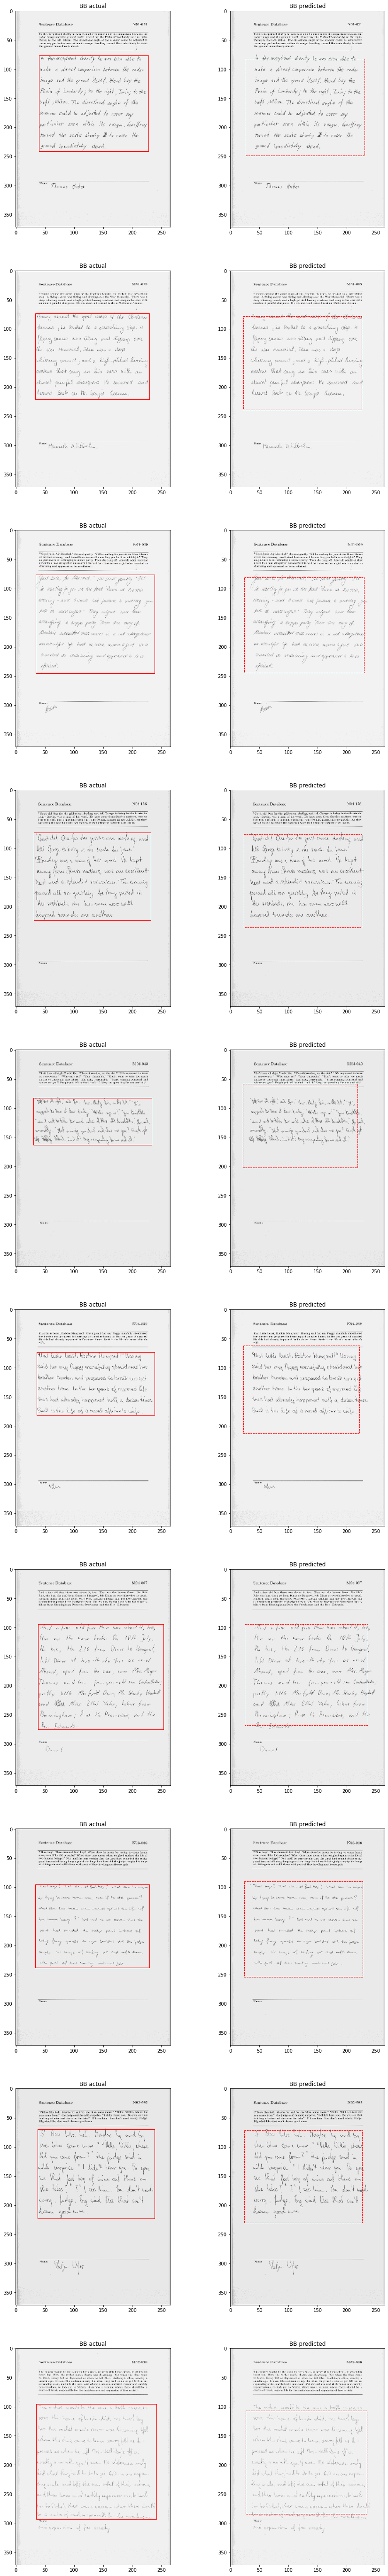

In [26]:
figs_to_plot = 10
fig, axs = plt.subplots(figs_to_plot, 2, figsize=(15, 10 * figs_to_plot))

for i in range(figs_to_plot):
    n = int(random.random()*len(test_ds))
    image, bb = test_ds[n]

    image, _ = transform(image, bb)
    image = image.as_in_context(ctx)
    image = image.expand_dims(axis=0)
    bb_predicted = net(image)

    (x, y, w, h) = bb[0]
    axs[i][0].imshow(image.asnumpy().squeeze(), cmap='Greys_r')
    image_h, image_w = image.shape[-2:]
    (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
    axs[i][0].add_patch(rect)
    axs[i][0].set_title("BB actual")

    axs[i][1].imshow(image.asnumpy().squeeze(), cmap='Greys_r')
    (x, y, w, h) = bb_predicted[0].asnumpy()
    image_h, image_w = image.shape[-2:]
    (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r", ls="--")
    axs[i][1].add_patch(rect)
    axs[i][1].set_title("BB predicted")